In [137]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
import numpy as np
import helper
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data/preprocessed/combined.csv')
gdf_stations = helper.create_stations_gdf(df)
gdf_rides = helper.create_rides_gdf(df)

/Users/manuel/Documents/Semester 2/Geospatial Data Science/Exam_Project_Geospatial/helper.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides["geometry"] = df_rides.apply(


In [10]:
gdf_stations = gdf_stations.to_crs(epsg=3857)
gdf_rides = gdf_rides.to_crs(epsg=3857)

In [11]:
gdf_rides_sample = gdf_rides.sample(n=1000)

In [16]:
gdf_rides_sample.head(5)

,start_station_id,end_station_id,started_at,ended_at,duration,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_name,end_station_description,end_station_latitude,end_station_longitude,geometry
3536399,622,439,2020-09-19 14:50:15.213000+00:00,2020-09-19 14:57:59.848000+00:00,464,Pilestredet 63,ved trikkestoppet,59.923883,10.731363,Mølleparken,ved Sannerbrua,59.928393,10.755969,"LINESTRING (1194609.831 8382810.652, 1197349.0..."
3201737,617,446,2021-05-18 09:38:05.253000+00:00,2021-05-18 09:59:46.314000+00:00,1301,Bjerregaardsgate Øst,ved Uelands gate,59.927168,10.749755,Bislett Stadion,ved rundkjøringen,59.925471,10.731219,"LINESTRING (1196657.204 8383540.404, 1194593.8..."
2019699,437,607,2019-07-20 15:08:33.547000+00:00,2019-07-20 15:22:12.404000+00:00,818,Sentrum Scene,ved Arbeidersamfunnets plass,59.915468,10.751141,Marcus Thranes gate,ved Akerselva,59.932747,10.758570,"LINESTRING (1196811.527 8380941.740, 1197638.5..."
4667106,503,465,2022-07-26 06:22:18.280000+00:00,2022-07-26 06:33:39.440000+00:00,681,Fagerheimgata,ved Dælenenga busstopp,59.927606,10.765985,Bjørvika,under broen Nylandsveien,59.909006,10.756180,"LINESTRING (1198463.935 8383637.741, 1197372.4..."
3032570,744,512,2021-04-08 13:47:46.253000+00:00,2021-04-08 13:59:05.727000+00:00,679,Hallénparken,ved Vogts gate,59.931530,10.762169,Ensjø T-bane,langs Ensjøveien,59.913189,10.789760,"LINESTRING (1198039.173 8384509.594, 1201110.6..."


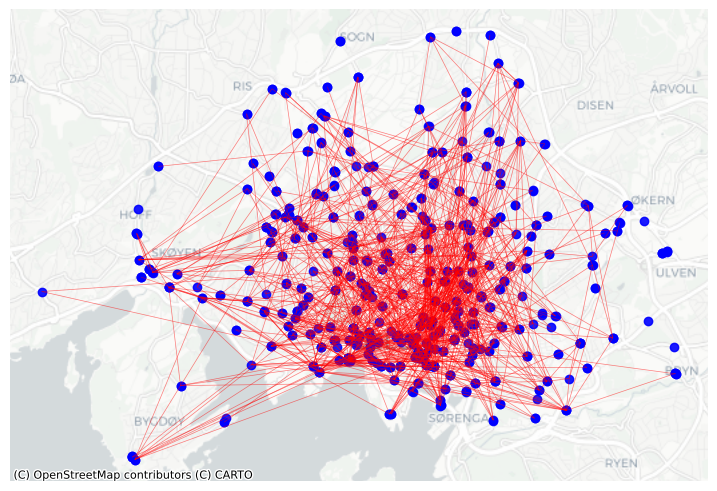

In [15]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rides_sample.plot(linewidth= 0.5, alpha=0.5, ax=ax, color='red')
gdf_stations.plot(alpha=0.9, ax=ax, color='blue')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations.crs, source=cx.providers.CartoDB.Positron)

In [132]:
gdf_rides_unique = gdf_rides.drop_duplicates(subset=['start_station_id','end_station_id'])

In [29]:
len(gdf_rides_unique)

76712

In [39]:
gdf_rides_unique_test = gdf_rides.drop_duplicates(subset=['geometry'])

In [40]:
len(gdf_rides_unique_test)

111388

In [107]:
rides_count =gdf_rides.groupby(['start_station_id', 'end_station_id'])['start_station_latitude'].count()

In [108]:
testdf = pd.DataFrame(data=rides_count.index, columns=['station_ids'])

In [109]:
testdf.head(5)

,station_ids
0,"(377, 377)"
1,"(377, 378)"
2,"(377, 380)"
3,"(377, 381)"
4,"(377, 382)"


In [110]:
testdf2 = pd.DataFrame(data=rides_count.values, columns=['count'])

In [111]:
testdf2.head(5)

,count
0,542
1,14
2,89
3,202
4,15


In [112]:
rides_count_df = pd.merge(testdf, testdf2, left_index=True, right_index=True)

In [113]:
rides_count_df.head(5)

,station_ids,count
0,"(377, 377)",542
1,"(377, 378)",14
2,"(377, 380)",89
3,"(377, 381)",202
4,"(377, 382)",15


In [114]:
rides_count_df[['start_station_id','end_station_id']] = rides_count_df.station_ids.apply( 
   lambda x: pd.Series(str(x).split(","))) 

In [115]:
rides_count_df['start_station_id'].str[1:]

0         377
1         377
2         377
3         377
4         377
         ... 
76707    4683
76708    4683
76709    4683
76710    4683
76711    4683
Name: start_station_id, Length: 76712, dtype: object

In [116]:
rides_count_df['start_station_id'] = rides_count_df['start_station_id'].str[1:]
rides_count_df['end_station_id'] = rides_count_df['end_station_id'].str.rstrip(')')

In [120]:
for i in range (len(gdf_rides_unique)):
    for j in range (len(rides_count_df)):
        if rides_count_df['start_station_id'][j] == gdf_rides_unique['start_station_id'][i] and rides_count_df['end_station_id'][j] == gdf_rides_unique['end_station_id'][i]:
            gdf_rides_unique['count'][i] = rides_count_df['count'][j]
            break   

KeyError: 61

In [129]:
rides_count_df['start_station_id'] = pd.to_numeric(rides_count_df['start_station_id'])
rides_count_df['end_station_id'] = pd.to_numeric(rides_count_df['end_station_id'])

In [130]:
rides_count_df.dtypes

station_ids         object
count                int64
start_station_id     int64
end_station_id       int64
dtype: object

In [134]:
gdf_rides_unique_count = pd.merge(gdf_rides_unique, rides_count_df, 'inner',on=['start_station_id', 'end_station_id'])

In [138]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(np.array(list(gdf_rides_unique_count['count'])).reshape(-1, 1))
gdf_rides_unique_count_scaled = gdf_rides_unique_count.copy()
gdf_rides_unique_count_scaled['count'] = min_max_scaler.transform(np.array(list(gdf_rides_unique_count['count'])).reshape(-1, 1))

In [139]:
gdf_rides_unique_count_scaled

,start_station_id,end_station_id,started_at,ended_at,duration,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_name,end_station_description,end_station_latitude,end_station_longitude,geometry,station_ids,count
0,507,2339,2023-10-01 00:00:40.773000+00:00,2023-10-01 00:04:34.682000+00:00,233,Jens Bjelkes Gate,ved Trondheimsveien,59.919147,10.764130,Elgsletta,langs Nylandsveien,59.915649,10.761725,"LINESTRING (1198257.424 8381758.913, 1197989.6...","(507, 2339)",0.019758
1,607,393,2023-10-01 03:01:18.390000+00:00,2023-10-01 03:08:24.193000+00:00,425,Marcus Thranes gate,ved Akerselva,59.932772,10.758595,Hans Nielsen Hauges plass,langs Hans Nielsen Hauges gate,59.939244,10.774319,"LINESTRING (1197641.308 8384785.559, 1199391.7...","(607, 393)",0.015494
2,500,506,2023-10-01 03:06:04.201000+00:00,2023-10-01 03:09:44.839000+00:00,220,Anker Hotel,langs Storgata,59.917279,10.758155,Botanisk Hage vest,ved Blytts gate,59.920128,10.768875,"LINESTRING (1197592.370 8381344.042, 1198785.7...","(500, 506)",0.026581
3,599,600,2023-10-01 03:23:28.695000+00:00,2023-10-01 03:30:50.497000+00:00,441,Paléhaven,langs Strandgata,59.910331,10.750110,Dyvekes bru,ved skatepark,59.905323,10.768958,"LINESTRING (1196696.771 8379801.076, 1198794.9...","(599, 600)",0.095522
4,597,568,2023-10-01 03:27:53.417000+00:00,2023-10-01 03:38:53.295000+00:00,659,Fredensborg,ved rundkjøringen,59.920995,10.750358,Frognerveien,ved Vestheimgata,59.917085,10.712880,"LINESTRING (1196724.378 8382169.263, 1192552.3...","(597, 568)",0.012793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76707,484,618,2023-09-29 15:02:05.515000+00:00,2023-09-29 15:23:02.229000+00:00,1256,Karenslyst allé,ved Skabos vei,59.920330,10.683814,Bak Niels Treschows hus sør,nærmest trikkestopp,59.942473,10.723715,"LINESTRING (1189316.734 8382021.562, 1193758.5...","(484, 618)",0.000000
76708,487,2350,2023-09-29 22:06:53.164000+00:00,2023-09-29 22:35:17.766000+00:00,1704,Carl Berners plass nord,ved Hasleveien,59.926929,10.776971,Blindern T-Bane,ved Blindernveien,59.940252,10.716724,"LINESTRING (1199686.924 8383487.374, 1192980.2...","(487, 2350)",0.000000
76709,522,466,2023-09-30 07:52:06.881000+00:00,2023-09-30 08:06:24.853000+00:00,857,Mandalls gate,ved Grønlandsleiret,59.912347,10.763815,Ullevålsalléen,langs Sognsveien,59.937913,10.730480,"LINESTRING (1198222.371 8380248.695, 1194511.5...","(522, 466)",0.000000
76710,2351,420,2023-09-30 10:02:50.978000+00:00,2023-09-30 10:13:25.436000+00:00,634,Sogn Studentby,Hjørnet av Sognsveien og Klaus Torgårds Vei,59.952084,10.727853,Bjølsendumpa,langs Treschows gate,59.940329,10.766137,"LINESTRING (1194219.110 8389077.730, 1198480.8...","(2351, 420)",0.000000
